In [17]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

In [2]:
#Set start and end dates for the analysis
start = datetime.datetime(2000,1,1)
end = datetime.datetime(2019,12,31)

In [3]:
#Get pricing data on a portfolio of 10 stocks chosed arbitrarily
jpm = web.DataReader('JPM','yahoo',start,end)
gs = web.DataReader('GS','yahoo',start,end)
jnj = web.DataReader('JNJ','yahoo',start,end)
bac = web.DataReader('BAC','yahoo',start,end)
toyota = web.DataReader('TM','yahoo',start,end)
exxon = web.DataReader('XOM','yahoo',start,end)
walmart = web.DataReader('WMT','yahoo',start,end)
cvs = web.DataReader('CVS','yahoo',start,end)
ge = web.DataReader('GE','yahoo',start,end)
costco = web.DataReader('COST','yahoo',start,end)

In [4]:
#Concatenate closing prices for the 10 stocks in the portfolio into a single dataframe
stocks = pd.concat([jpm['Close'],gs['Close'],jnj['Close'],bac['Close'],toyota['Close'],exxon['Close'],
                             walmart['Close'],cvs['Close'],ge['Close'],costco['Close']],axis=1)
stocks.columns= ['jpm','gs','jnj','bac','toyota','exxon','walmart','cvs','ge','costco']

In [5]:
stocks.head()

,jpm,gs,jnj,bac,toyota,exxon,walmart,cvs,ge,costco
Date,,,,,,,,,,
2000-01-03,48.583332,88.3125,46.09375,24.21875,97.125,39.15625,66.8125,18.90625,48.076923,44.500000
2000-01-04,47.250000,82.7500,44.40625,22.78125,92.625,38.40625,64.3125,18.75000,46.153847,42.062500
2000-01-05,46.958332,78.8750,44.87500,23.03125,93.000,40.50000,63.0000,19.78125,46.073719,42.781250
2000-01-06,47.625000,82.2500,46.28125,25.00000,84.750,42.59375,63.6875,18.37500,46.689705,43.640625
2000-01-07,48.500000,82.5625,48.25000,24.34375,86.000,42.46875,68.5000,18.81250,48.497597,46.531250


In [6]:
#Calculate log daily returns
log_ret = np.log(stocks/stocks.shift(1))

In [7]:
log_ret.head()

,jpm,gs,jnj,bac,toyota,exxon,walmart,cvs,ge,costco
Date,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-0.027828,-0.065058,-0.037297,-0.061189,-0.047440,-0.019340,-0.038136,-0.008299,-0.040822,-0.056333
2000-01-05,-0.006192,-0.047960,0.010501,0.010914,0.004040,0.053082,-0.020619,0.053541,-0.001738,0.016943
2000-01-06,0.014097,0.041899,0.030856,0.082024,-0.092894,0.050406,0.010854,-0.073743,0.013281,0.019889
2000-01-07,0.018206,0.003792,0.041659,-0.026601,0.014642,-0.002939,0.072845,0.023530,0.037991,0.064136


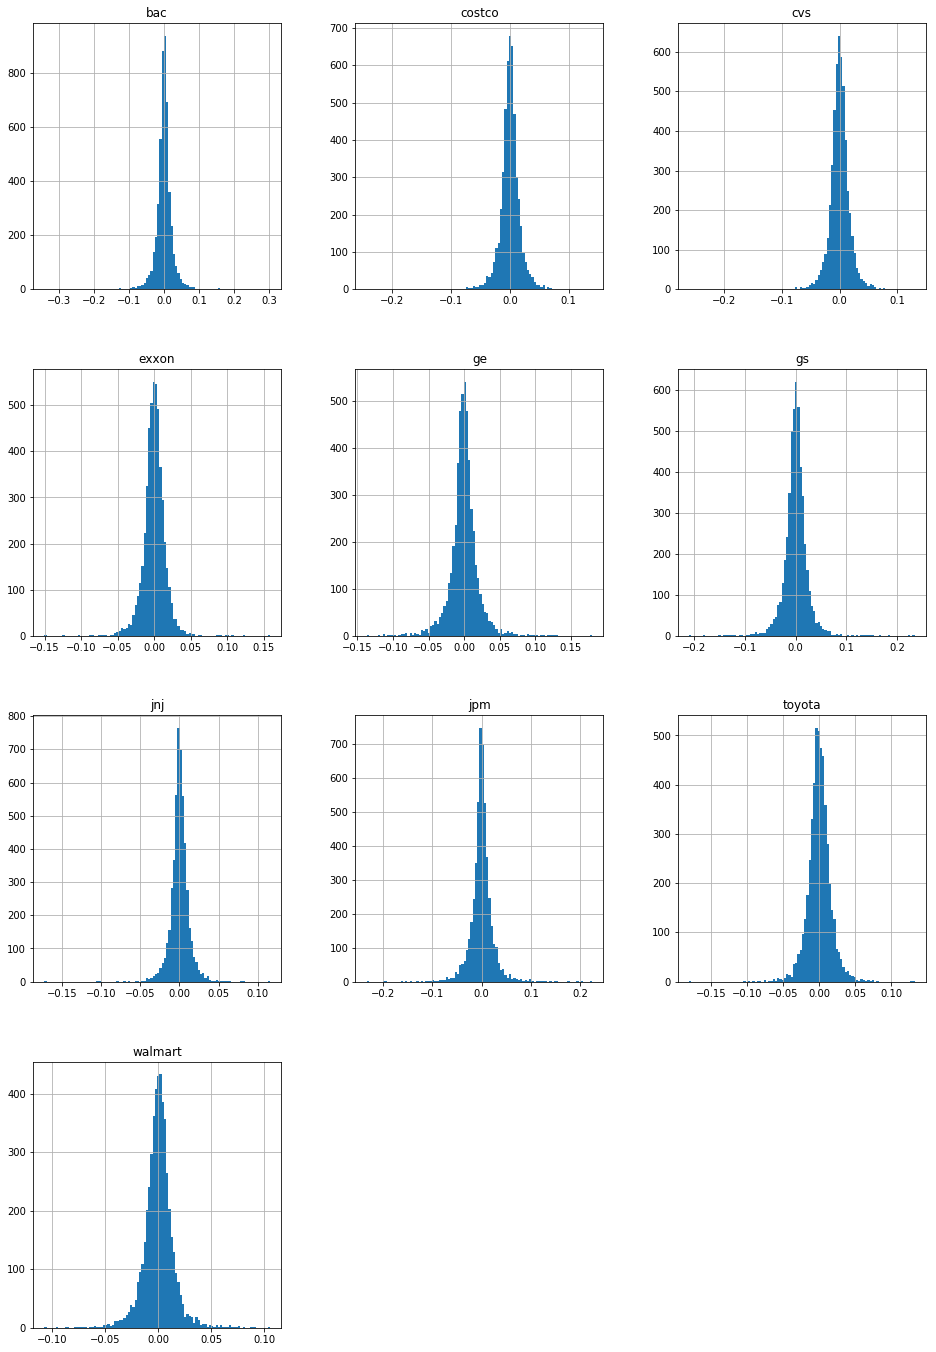

In [8]:
#Returns distributions
log_ret.hist(bins=100,figsize=(16,24));

In [9]:
#Mean annualized return
log_ret.mean()*252

jpm        0.052808
gs         0.047940
jnj        0.057716
bac        0.018762
toyota     0.018511
exxon      0.028947
walmart    0.028852
cvs        0.068560
ge        -0.073168
costco     0.094579
dtype: float64

## Random weight allocation by trial and error

In [10]:
num_ports = 50000

all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # Create Random Weights
    weights = np.array(np.random.random(10))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)

    # Expected Variance
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [11]:
#Max Sharpe Ratio generated
sharpe_arr.max()

0.34076174652225416

In [12]:
#Index in the array for max Sharpe ratio
max_sharpe_index = sharpe_arr.argmax()
max_sharpe_index

47711

In [13]:
#Weights for each stock to generate portfolio with highest Sharpe ratio
all_weights[max_sharpe_index,:]

array([0.06887452, 0.03235557, 0.25338384, 0.01112952, 0.00213956,
       0.13341713, 0.01709709, 0.20134584, 0.01652666, 0.26373027])

In [14]:
#Save return and volatility for optimal portfolio
max_sr_ret = ret_arr[max_sharpe_index]
max_sr_vol = vol_arr[max_sharpe_index]

## Plotting data to create the efficient frontier

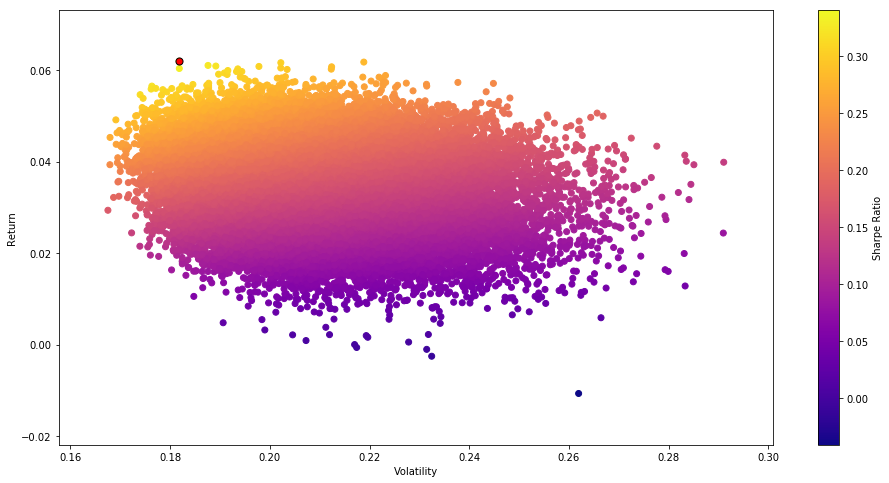

In [15]:
plt.figure(figsize=(16,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add red dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')

## Using optimization functions to find optimal portfolio

In [16]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [18]:
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

In [19]:
# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

In [20]:
# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

In [22]:
# 0-1 bounds for each weight
bounds = ((0, 1), (0, 1), (0, 1), (0, 1),(0, 1), (0, 1), (0, 1), (0, 1),(0, 1), (0, 1))

In [23]:
# Initial Guess (equal distribution)
init_guess = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

In [24]:
# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [25]:
opt_results

     fun: -0.4065091856035376
     jac: array([ 9.85812247e-02,  8.16477127e-02,  1.14928931e-04,  2.91662954e-01,
        1.18503101e-01,  9.38709341e-02,  1.39913559e-01,  6.84671104e-05,
        7.26389613e-01, -1.59282237e-04])
 message: 'Optimization terminated successfully.'
    nfev: 84
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.00000000e+00, 1.05679057e-17, 4.74629378e-01, 3.83961726e-17,
       1.32191397e-16, 0.00000000e+00, 0.00000000e+00, 1.27911520e-01,
       2.69323704e-16, 3.97459101e-01])

In [26]:
opt_results.x

array([0.00000000e+00, 1.05679057e-17, 4.74629378e-01, 3.83961726e-17,
       1.32191397e-16, 0.00000000e+00, 0.00000000e+00, 1.27911520e-01,
       2.69323704e-16, 3.97459101e-01])

In [27]:
get_ret_vol_sr(opt_results.x)

array([0.07375468, 0.18143422, 0.40650919])

In [28]:
# Our returns go from 0 to somewhere along 0.3
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(0,0.3,100) # Change 100 to a lower number for slower computers!

In [29]:
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

In [30]:
frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

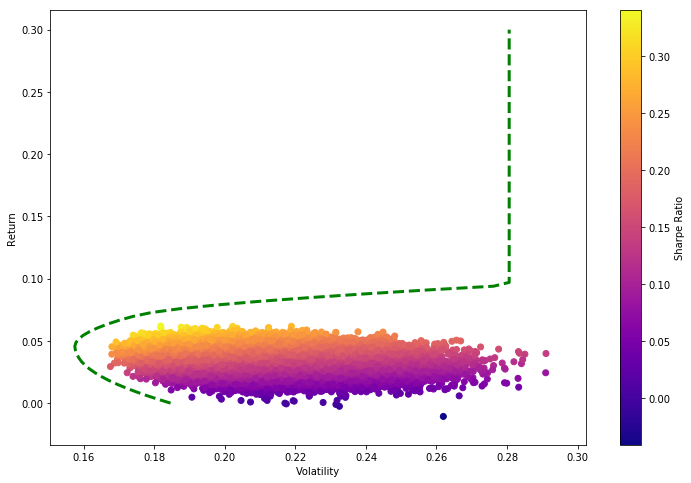

In [31]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')



# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)